In [1]:
import numpy as np 
import pandas as pd 
from tqdm import tqdm
from collections import Counter 
import matplotlib.pyplot as plt 
from sklearn.metrics import classification_report

from pyts.image import RecurrencePlot
from pyts.image import GramianAngularField
from pyts.image import MarkovTransitionField

import torch 
import torch.nn as nn 
import torch.optim as optim
from torchvision import models
from torchvision import transforms
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

import warnings 
warnings.filterwarnings('ignore')

In [2]:
"""
Things to do 
1. Create GAF, RP and MTF images ✔️
2. Create a dataset of those images ✔️
3. Build MIF (MultiModal Image fusion) model✔️
4. Build MFF (Multimodal feature fusion) model 
5. Test the model 
"""

'\nThings to do \n1. Create GAF, RP and MTF images ✔️\n2. Create a dataset of those images ✔️\n3. Build MIF (MultiModal Image fusion) model✔️\n4. Build MFF (Multimodal feature fusion) model \n5. Test the model \n'

##### Read Data

In [3]:
ptdb_abnormal_df = pd.read_csv("Dataset\ptbdb_abnormal.csv", header=None)
ptdb_normal_df = pd.read_csv("Dataset\ptbdb_normal.csv", header=None)

ptdb_abnormal_df = ptdb_abnormal_df.sample(n=ptdb_normal_df.shape[0], random_state=42)

In [4]:
print("Labels Info (Train):")
print(ptdb_abnormal_df[187].value_counts(), "\n")

print("Labels Info (Test):")
print(ptdb_normal_df[187].value_counts())

Labels Info (Train):
187
1.0    4046
Name: count, dtype: int64 

Labels Info (Test):
187
0.0    4046
Name: count, dtype: int64


In [5]:
abnormal_features_df = ptdb_abnormal_df.iloc[:, :-1].values
abnormal_labels_df = ptdb_abnormal_df.iloc[:, -1].values

print(f"Features size of abnormal df: {abnormal_features_df.shape}")
print(f"Labels size of abnormal df: {abnormal_labels_df.shape}")

Features size of abnormal df: (4046, 187)
Labels size of abnormal df: (4046,)


In [6]:
normal_features_df = ptdb_normal_df.iloc[:, :-1].values
normal_labels_df = ptdb_normal_df.iloc[:, -1].values

print(f"Features size of abnormal df: {normal_features_df.shape}")
print(f"Labels size of abnormal df: {normal_labels_df.shape}")

Features size of abnormal df: (4046, 187)
Labels size of abnormal df: (4046,)


##### Time Series to Images

GRAMIAN ANGULAR FIELD 

In [7]:
def convert_to_gaf_images(features, image_size=64):
    gaf_transformer = GramianAngularField(image_size=image_size, method='summation')
    gaf_images = [gaf_transformer.fit_transform(x.reshape(1, -1))[0] for x in features]
    gaf_images = np.array(gaf_images)

    return gaf_images

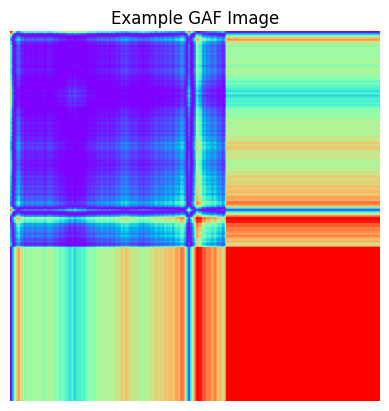

GAF images shape: (4046, 187, 187)
Labels shape: (4046,)


In [8]:
gaf_images = convert_to_gaf_images(abnormal_features_df, image_size=187)

plt.imshow(gaf_images[0], cmap='rainbow')
plt.axis('off')
plt.title("Example GAF Image")
plt.show()

print("GAF images shape:", gaf_images.shape)  
print("Labels shape:", abnormal_labels_df.shape)

MARKOV TRANSITION FIELD 

In [9]:
def convert_to_mtf_images(features, image_size=64):
    mtf_transformer = MarkovTransitionField(image_size=image_size)
    mtf_images = [mtf_transformer.fit_transform(x.reshape(1, -1))[0] for x in features]
    mtf_images = np.array(mtf_images)
    return mtf_images

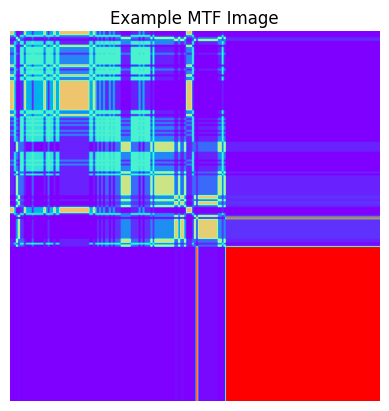

MTF images shape: (4046, 187, 187)


In [10]:
mtf_images = convert_to_mtf_images(abnormal_features_df, image_size=187)

plt.imshow(mtf_images[0], cmap='rainbow')
plt.axis('off')
plt.title("Example MTF Image")
plt.show()

print("MTF images shape:", mtf_images.shape)

RECURRENCE PLOT 

In [11]:
def convert_to_rp_images(features, image_size=64):
    rp_transformer = RecurrencePlot(dimension=1, time_delay=1, threshold='point', percentage=20)
    rp_images = [rp_transformer.fit_transform(x.reshape(1, -1))[0] for x in features]
    rp_images = np.array(rp_images)
    return rp_images

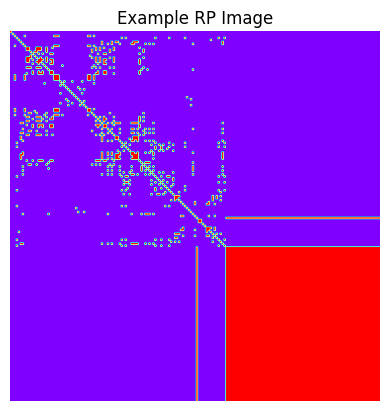

RP images shape: (4046, 187, 187)


In [12]:
rp_images = convert_to_rp_images(abnormal_features_df, image_size=64)

plt.imshow(rp_images[0], cmap='rainbow')
plt.axis('off')
plt.title("Example RP Image")
plt.show()

print("RP images shape:", rp_images.shape)

FUSED IMAGES

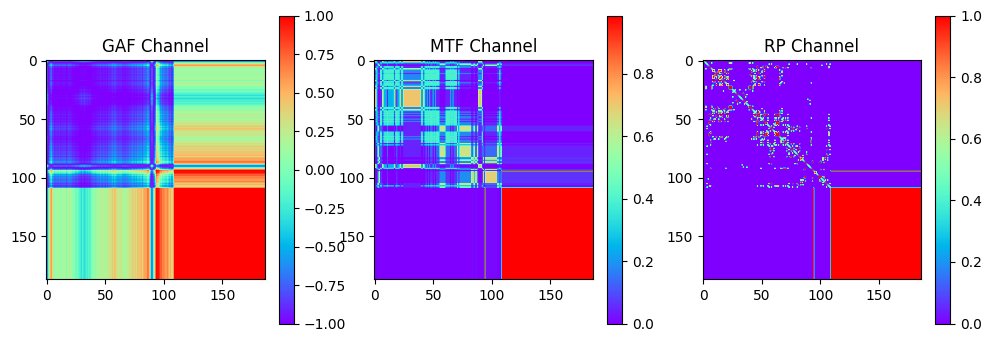

Fused images shape: (4046, 187, 187, 3)


In [13]:
fused_images = np.stack((gaf_images, mtf_images, rp_images), axis=-1)

plt.figure(figsize=(12, 4))
for i, (image, title) in enumerate(zip(fused_images[0].transpose(2, 0, 1), ['GAF', 'MTF', 'RP'])):
    plt.subplot(1, 3, i + 1)
    plt.imshow(image, cmap='rainbow')
    plt.title(f"{title} Channel")
    plt.colorbar()
plt.show()

print("Fused images shape:", fused_images.shape)

##### Create Dataset

In [14]:
class ECGFusedImageDataset(Dataset):
    def __init__(self, df, image_size=187):

        self.features = df.iloc[:, :-1].values  
        self.labels = df.iloc[:, -1].values     
        self.image_size = image_size

        self.gaf_transformer = GramianAngularField(image_size=image_size, method='summation')
        self.mtf_transformer = MarkovTransitionField(image_size=image_size)
        self.rp_transformer = RecurrencePlot(dimension=1, time_delay=1, threshold='point', percentage=20)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        ecg_signal = self.features[idx]
        label = int(self.labels[idx])

        gaf_image = self.gaf_transformer.fit_transform(ecg_signal.reshape(1, -1))[0]
        mtf_image = self.mtf_transformer.fit_transform(ecg_signal.reshape(1, -1))[0]
        rp_image = self.rp_transformer.fit_transform(ecg_signal.reshape(1, -1))[0]

        fused_image = np.stack((gaf_image, mtf_image, rp_image), axis=-1)

        fused_image = torch.tensor(fused_image, dtype=torch.float32).permute(2, 0, 1)

        return fused_image, label

In [15]:
combined_df = pd.concat([ptdb_abnormal_df, ptdb_normal_df], ignore_index=True)
combined_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)

image_size = 187
dataset = ECGFusedImageDataset(combined_df, image_size=image_size)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Fused image shape: torch.Size([3, 187, 187])
Label: 0


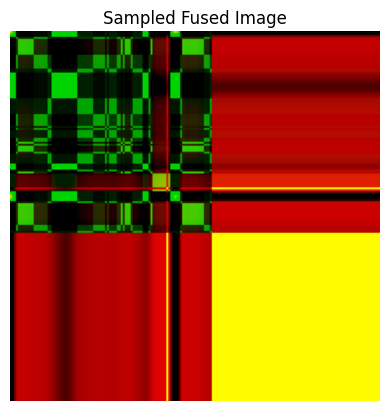

In [16]:
fused_image, label = dataset[0]
print("Fused image shape:", fused_image.shape)  
print("Label:", label)
plt.imshow(fused_image.permute(1, 2, 0), cmap='rainbow')
plt.axis('off')
plt.title("Sampled Fused Image")
plt.show()

##### Multi-Modal Image Fusion Network 

In [17]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=10, device="cuda"):
    model = model.to(device)
    
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  
                print("Training Phase")
            else:
                model.eval()  
                print("Validation Phase")
                
            running_loss = 0.0
            running_corrects = 0
            
            with tqdm(total=len(dataloaders[phase]), desc=f"{phase.capitalize()} Progress", unit="batch") as pbar:
                for inputs, labels in dataloaders[phase]:
                    inputs, labels = inputs.to(device), labels.to(device)
                    
                    optimizer.zero_grad()
                    
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data).item()  # Convert to Python scalar
                    
                    pbar.update(1)
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects / len(dataloaders[phase].dataset)  # Convert to scalar
            
            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc)
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc)
    
    print("\nTraining complete")
    return model, history


def evaluate_model(model, dataloader, device="cuda"):
    model = model.to(device)
    model.eval()  
    
    all_preds = []
    all_labels = []
    
    print("\nEvaluating Model")
    with tqdm(total=len(dataloader), desc="Evaluation Progress", unit="batch") as pbar:
        with torch.no_grad():
            for inputs, labels in dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                
                pbar.update(1)
    
    accuracy = (np.array(all_preds) == np.array(all_labels)).mean()
    print(f"\nTest Accuracy: {accuracy:.4f}")
    
    report = classification_report(all_labels, all_preds, target_names=["Normal", "Abnormal"])
    print("\nClassification Report:\n")
    print(report)

In [18]:
image_size = 187
batch_size = 32
dataset = ECGFusedImageDataset(combined_df, image_size=image_size)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
print(f"Number of samples in train set: {len(train_dataset)}")
print(f"Number of samples in validation set: {len(val_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
dataloaders = {'train': train_loader, 'val': val_loader}

Number of samples in train set: 6473
Number of samples in validation set: 1619


In [19]:
model = models.alexnet(pretrained=True)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 2)  

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [20]:
mif_trained_model, mif_history = train_model(model, dataloaders, criterion, optimizer, num_epochs=20, device="cuda")
evaluate_model(mif_trained_model, val_loader, device="cuda")


Epoch 1/20
Training Phase


Train Progress: 100%|██████████| 203/203 [00:34<00:00,  5.82batch/s]


Train Loss: 0.2903 Acc: 0.8797
Validation Phase


Val Progress: 100%|██████████| 51/51 [00:03<00:00, 14.24batch/s]


Val Loss: 0.1630 Acc: 0.9389

Epoch 2/20
Training Phase


Train Progress: 100%|██████████| 203/203 [00:19<00:00, 10.34batch/s]


Train Loss: 0.1294 Acc: 0.9516
Validation Phase


Val Progress: 100%|██████████| 51/51 [00:03<00:00, 15.16batch/s]


Val Loss: 0.1567 Acc: 0.9382

Epoch 3/20
Training Phase


Train Progress: 100%|██████████| 203/203 [00:19<00:00, 10.50batch/s]


Train Loss: 0.0728 Acc: 0.9717
Validation Phase


Val Progress: 100%|██████████| 51/51 [00:03<00:00, 15.28batch/s]


Val Loss: 0.1044 Acc: 0.9599

Epoch 4/20
Training Phase


Train Progress: 100%|██████████| 203/203 [00:18<00:00, 10.72batch/s]


Train Loss: 0.0537 Acc: 0.9815
Validation Phase


Val Progress: 100%|██████████| 51/51 [00:03<00:00, 14.25batch/s]


Val Loss: 0.0836 Acc: 0.9679

Epoch 5/20
Training Phase


Train Progress: 100%|██████████| 203/203 [00:19<00:00, 10.16batch/s]


Train Loss: 0.0382 Acc: 0.9861
Validation Phase


Val Progress: 100%|██████████| 51/51 [00:03<00:00, 15.11batch/s]


Val Loss: 0.2431 Acc: 0.9043

Epoch 6/20
Training Phase


Train Progress: 100%|██████████| 203/203 [00:18<00:00, 10.69batch/s]


Train Loss: 0.0305 Acc: 0.9886
Validation Phase


Val Progress: 100%|██████████| 51/51 [00:03<00:00, 16.04batch/s]


Val Loss: 0.1249 Acc: 0.9679

Epoch 7/20
Training Phase


Train Progress: 100%|██████████| 203/203 [00:18<00:00, 10.72batch/s]


Train Loss: 0.0152 Acc: 0.9949
Validation Phase


Val Progress: 100%|██████████| 51/51 [00:03<00:00, 15.02batch/s]


Val Loss: 0.1187 Acc: 0.9728

Epoch 8/20
Training Phase


Train Progress: 100%|██████████| 203/203 [00:19<00:00, 10.47batch/s]


Train Loss: 0.0336 Acc: 0.9893
Validation Phase


Val Progress: 100%|██████████| 51/51 [00:04<00:00, 12.57batch/s]


Val Loss: 0.1056 Acc: 0.9765

Epoch 9/20
Training Phase


Train Progress: 100%|██████████| 203/203 [00:19<00:00, 10.44batch/s]


Train Loss: 0.0146 Acc: 0.9954
Validation Phase


Val Progress: 100%|██████████| 51/51 [00:03<00:00, 14.97batch/s]


Val Loss: 0.1446 Acc: 0.9605

Epoch 10/20
Training Phase


Train Progress: 100%|██████████| 203/203 [00:19<00:00, 10.60batch/s]


Train Loss: 0.0146 Acc: 0.9964
Validation Phase


Val Progress: 100%|██████████| 51/51 [00:03<00:00, 15.93batch/s]


Val Loss: 0.1180 Acc: 0.9679

Epoch 11/20
Training Phase


Train Progress: 100%|██████████| 203/203 [00:19<00:00, 10.54batch/s]


Train Loss: 0.0167 Acc: 0.9946
Validation Phase


Val Progress: 100%|██████████| 51/51 [00:03<00:00, 14.77batch/s]


Val Loss: 0.0812 Acc: 0.9815

Epoch 12/20
Training Phase


Train Progress: 100%|██████████| 203/203 [00:19<00:00, 10.27batch/s]


Train Loss: 0.0259 Acc: 0.9918
Validation Phase


Val Progress: 100%|██████████| 51/51 [00:03<00:00, 15.27batch/s]


Val Loss: 0.0961 Acc: 0.9734

Epoch 13/20
Training Phase


Train Progress: 100%|██████████| 203/203 [00:18<00:00, 10.89batch/s]


Train Loss: 0.0185 Acc: 0.9932
Validation Phase


Val Progress: 100%|██████████| 51/51 [00:03<00:00, 15.44batch/s]


Val Loss: 0.0690 Acc: 0.9802

Epoch 14/20
Training Phase


Train Progress: 100%|██████████| 203/203 [00:18<00:00, 10.76batch/s]


Train Loss: 0.0061 Acc: 0.9975
Validation Phase


Val Progress: 100%|██████████| 51/51 [00:03<00:00, 12.95batch/s]


Val Loss: 0.1060 Acc: 0.9734

Epoch 15/20
Training Phase


Train Progress: 100%|██████████| 203/203 [00:19<00:00, 10.62batch/s]


Train Loss: 0.0119 Acc: 0.9963
Validation Phase


Val Progress: 100%|██████████| 51/51 [00:03<00:00, 14.31batch/s]


Val Loss: 0.1008 Acc: 0.9821

Epoch 16/20
Training Phase


Train Progress: 100%|██████████| 203/203 [00:19<00:00, 10.66batch/s]


Train Loss: 0.0118 Acc: 0.9958
Validation Phase


Val Progress: 100%|██████████| 51/51 [00:03<00:00, 15.87batch/s]


Val Loss: 0.0682 Acc: 0.9771

Epoch 17/20
Training Phase


Train Progress: 100%|██████████| 203/203 [00:19<00:00, 10.45batch/s]


Train Loss: 0.0020 Acc: 0.9997
Validation Phase


Val Progress: 100%|██████████| 51/51 [00:03<00:00, 14.94batch/s]


Val Loss: 0.1481 Acc: 0.9728

Epoch 18/20
Training Phase


Train Progress: 100%|██████████| 203/203 [00:19<00:00, 10.64batch/s]


Train Loss: 0.0179 Acc: 0.9949
Validation Phase


Val Progress: 100%|██████████| 51/51 [00:03<00:00, 15.22batch/s]


Val Loss: 0.1118 Acc: 0.9617

Epoch 19/20
Training Phase


Train Progress: 100%|██████████| 203/203 [00:23<00:00,  8.65batch/s]


Train Loss: 0.0172 Acc: 0.9938
Validation Phase


Val Progress: 100%|██████████| 51/51 [00:04<00:00, 10.33batch/s]


Val Loss: 0.0738 Acc: 0.9809

Epoch 20/20
Training Phase


Train Progress: 100%|██████████| 203/203 [00:20<00:00,  9.97batch/s]


Train Loss: 0.0023 Acc: 0.9995
Validation Phase


Val Progress: 100%|██████████| 51/51 [00:03<00:00, 15.06batch/s]


Val Loss: 0.1127 Acc: 0.9759

Training complete

Evaluating Model


Evaluation Progress: 100%|██████████| 51/51 [00:03<00:00, 13.97batch/s]


Test Accuracy: 0.9759

Classification Report:

              precision    recall  f1-score   support

      Normal       0.97      0.98      0.98       788
    Abnormal       0.98      0.97      0.98       831

    accuracy                           0.98      1619
   macro avg       0.98      0.98      0.98      1619
weighted avg       0.98      0.98      0.98      1619



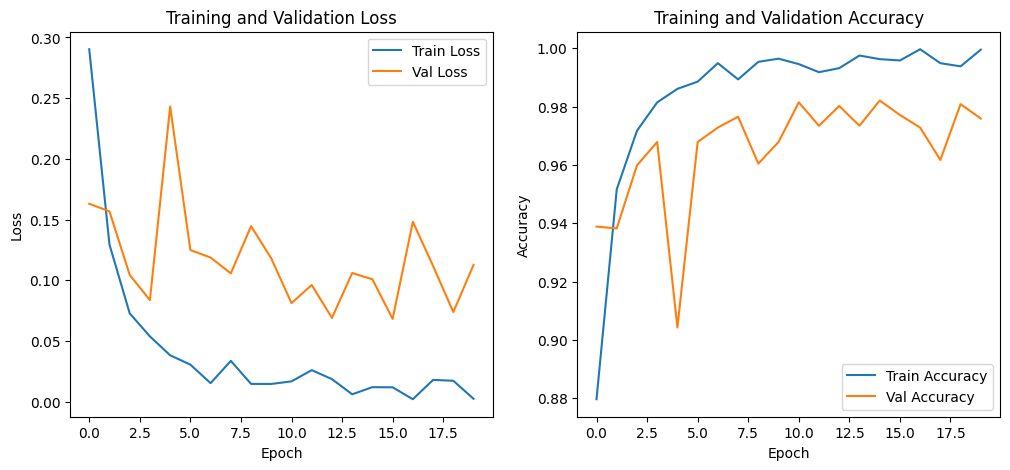

In [21]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(mif_history['train_loss'], label='Train Loss')
plt.plot(mif_history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(mif_history['train_acc'], label='Train Accuracy')
plt.plot(mif_history['val_acc'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

In [60]:
def visualize_sample_prediction(model, dataset, idx, device="cuda"):
    class_mapping = {0: "Normal", 1: "Myocardial Infarction"}
    
    model = model.to(device)
    model.eval()
    
    sample, label = dataset[idx]  
    sample = sample.unsqueeze(0).to(device)  
    
    with torch.no_grad():
        output = model(sample) 
        _, predicted_label = torch.max(output, 1)
    
    sample_np = sample.squeeze(0).cpu().permute(1, 2, 0).numpy()  
    
    plt.figure(figsize=(4, 4))
    plt.imshow(sample_np, cmap="viridis")
    plt.title("Input Sample")
    plt.axis("off")
    plt.show()
    
    print(f"Ground Truth Label: {label} ({class_mapping[label]})")
    print(f"Predicted Label: {predicted_label.item()} ({class_mapping[predicted_label.item()]})")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


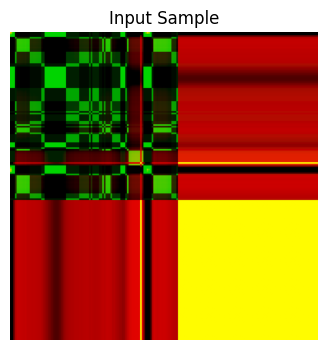

Ground Truth Label: 0 (Normal)
Predicted Label: 0 (Normal)


In [61]:
sample_idx = 0  
visualize_sample_prediction(mif_trained_model, dataset, sample_idx, device="cuda")

##### Multi-Modal Feature Fusion Network 

In [22]:
class ECGFusedImageDataset_MFF(Dataset):
    def __init__(self, df):
        self.features = df.iloc[:, :-1].values  
        self.labels = df.iloc[:, -1].values    

        self.resize_transform = transforms.Resize((224, 224))

        self.gaf_transformer = GramianAngularField(image_size=187, method='summation')
        self.mtf_transformer = MarkovTransitionField(image_size=187)
        self.rp_transformer = RecurrencePlot(dimension=1, time_delay=1, threshold='point', percentage=20)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        ecg_signal = self.features[idx]
        label = int(self.labels[idx])

        gaf_image = self.gaf_transformer.fit_transform(ecg_signal.reshape(1, -1))[0]
        mtf_image = self.mtf_transformer.fit_transform(ecg_signal.reshape(1, -1))[0]
        rp_image = self.rp_transformer.fit_transform(ecg_signal.reshape(1, -1))[0]

        gaf_image = torch.tensor(gaf_image, dtype=torch.float32).unsqueeze(0).repeat(3, 1, 1)  
        mtf_image = torch.tensor(mtf_image, dtype=torch.float32).unsqueeze(0).repeat(3, 1, 1)  
        rp_image = torch.tensor(rp_image, dtype=torch.float32).unsqueeze(0).repeat(3, 1, 1)    

        gaf_image = self.resize_transform(gaf_image)
        mtf_image = self.resize_transform(mtf_image)
        rp_image = self.resize_transform(rp_image)

        label = torch.tensor(label, dtype=torch.long)

        return gaf_image, mtf_image, rp_image, label

In [23]:
class AlexNetFeatureExtractor(nn.Module):
    def __init__(self):
        super(AlexNetFeatureExtractor, self).__init__()
        self.alexnet = models.alexnet(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(self.alexnet.classifier.children())[:-1])

    def forward(self, x):
        x = self.alexnet.features(x)
        x = torch.flatten(x, 1)
        x = self.feature_extractor(x)
        return x

class HighBoostFilter(nn.Module):
    def __init__(self, amplification_factor=9):
        super(HighBoostFilter, self).__init__()
        self.kernel = torch.tensor([[-1, -1, -1],
                                    [-1, amplification_factor, -1],
                                    [-1, -1, -1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        self.kernel = nn.Parameter(self.kernel, requires_grad=False)  

    def forward(self, x):
        x = F.conv2d(x, self.kernel, padding=1)
        return x

class GatedFusionNetwork(nn.Module):
    def __init__(self, feature_dim):
        super(GatedFusionNetwork, self).__init__()
        self.high_boost_filter = HighBoostFilter()
        self.sigmoid = nn.Sigmoid()

    def forward(self, f1, f2, f3):
        f1 = f1.view(f1.size(0), 1, 64, 64)  
        f2 = f2.view(f2.size(0), 1, 64, 64)
        f3 = f3.view(f3.size(0), 1, 64, 64)

        w1 = self.sigmoid(self.high_boost_filter(f1))
        w2 = self.sigmoid(self.high_boost_filter(f2))
        w3 = self.sigmoid(self.high_boost_filter(f3))

        fused_features = (w1 * f1) + (w2 * f2) + (w3 * f3)
        fused_features = fused_features.view(fused_features.size(0), -1)
        return fused_features

class FusionCNNClassifier(nn.Module):
    def __init__(self):
        super(FusionCNNClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=1, padding=2)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc = nn.Linear(2048, 2)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


class MultimodalFeatureFusionModel(nn.Module):
    def __init__(self, feature_dim=4096):
        super(MultimodalFeatureFusionModel, self).__init__()
        self.alexnet_gaf = AlexNetFeatureExtractor()
        self.alexnet_mtf = AlexNetFeatureExtractor()
        self.alexnet_rp = AlexNetFeatureExtractor()

        self.gfn = GatedFusionNetwork(feature_dim)

        self.classifier = FusionCNNClassifier()

    def forward(self, gaf_img, mtf_img, rp_img):
        f1 = self.alexnet_gaf(gaf_img)
        f2 = self.alexnet_mtf(mtf_img)
        f3 = self.alexnet_rp(rp_img)

        fused_features = self.gfn(f1, f2, f3)
        fused_features = fused_features.view(fused_features.size(0), 1, 64, 64)  

        output = self.classifier(fused_features)
        return output


In [27]:
def train_mff_model(model, dataloaders, criterion, optimizer, num_epochs=10, device="cuda"):
    history = {
        'train_loss': [], 
        'val_loss': [], 
        'train_acc': [], 
        'val_acc': []
        }
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Training mode
                print("Training Phase")
            else:
                model.eval()  # Evaluation mode
                print("Validation Phase")
                
            running_loss = 0.0
            running_corrects = 0
            
            with tqdm(total=len(dataloaders[phase]), desc=f"{phase.capitalize()} Progress", unit="batch") as pbar:
                for gaf_img, mtf_img, rp_img, labels in dataloaders[phase]:
                    gaf_img, mtf_img, rp_img, labels = (
                        gaf_img.to(device), mtf_img.to(device), rp_img.to(device), labels.to(device)
                    )
                    
                    optimizer.zero_grad()
                    
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(gaf_img, mtf_img, rp_img)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    
                    # Ensure proper scalar conversion
                    running_loss += loss.item() * labels.size(0)
                    running_corrects += torch.sum(preds == labels.data).item()
                    
                    pbar.update(1)
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects / len(dataloaders[phase].dataset)
            
            # Store metrics (explicit scalar conversion)
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc)
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc)
                
            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
    
    print("\nTraining complete")
    return model, history


def evaluate_model(model, dataloader, device="cuda"):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        with tqdm(total=len(dataloader), desc="Evaluation Progress", unit="batch") as pbar:
            for gaf_img, mtf_img, rp_img, labels in dataloader:
                gaf_img, mtf_img, rp_img, labels = (
                    gaf_img.to(device),
                    mtf_img.to(device),
                    rp_img.to(device),
                    labels.to(device),
                )

                outputs = model(gaf_img, mtf_img, rp_img)
                _, preds = torch.max(outputs, 1)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                pbar.update(1)

    accuracy = (np.array(all_preds) == np.array(all_labels)).mean()
    print(f"\nValidation Accuracy: {accuracy:.4f}")

    report = classification_report(all_labels, all_preds, target_names=["Normal", "Abnormal"])
    print("\nClassification Report:\n")
    print(report)

In [30]:
dataset = ECGFusedImageDataset_MFF(combined_df)

batch_size = 32
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
dataloaders = {'train': train_loader, 'val': val_loader}

device = "cuda" if torch.cuda.is_available() else "cpu"
model = MultimodalFeatureFusionModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [31]:
mff_trained_model, mff_history = train_mff_model(model, dataloaders, criterion, optimizer, num_epochs=10, device=device)


Epoch 1/10
Training Phase


Train Progress: 100%|██████████| 203/203 [00:47<00:00,  4.29batch/s]


Train Loss: 0.4697 Acc: 0.7843
Validation Phase


Val Progress: 100%|██████████| 51/51 [00:08<00:00,  6.36batch/s]


Val Loss: 0.3446 Acc: 0.8691

Epoch 2/10
Training Phase


Train Progress: 100%|██████████| 203/203 [00:46<00:00,  4.34batch/s]


Train Loss: 0.3208 Acc: 0.8619
Validation Phase


Val Progress: 100%|██████████| 51/51 [00:07<00:00,  6.47batch/s]


Val Loss: 0.3304 Acc: 0.8351

Epoch 3/10
Training Phase


Train Progress: 100%|██████████| 203/203 [00:47<00:00,  4.31batch/s]


Train Loss: 0.2415 Acc: 0.8962
Validation Phase


Val Progress: 100%|██████████| 51/51 [00:08<00:00,  6.25batch/s]


Val Loss: 0.2851 Acc: 0.8857

Epoch 4/10
Training Phase


Train Progress: 100%|██████████| 203/203 [00:49<00:00,  4.11batch/s]


Train Loss: 0.3124 Acc: 0.8573
Validation Phase


Val Progress: 100%|██████████| 51/51 [00:09<00:00,  5.39batch/s]


Val Loss: 0.2705 Acc: 0.9197

Epoch 5/10
Training Phase


Train Progress: 100%|██████████| 203/203 [00:51<00:00,  3.91batch/s]


Train Loss: 0.1598 Acc: 0.9407
Validation Phase


Val Progress: 100%|██████████| 51/51 [00:09<00:00,  5.48batch/s]


Val Loss: 0.1752 Acc: 0.9129

Epoch 6/10
Training Phase


Train Progress: 100%|██████████| 203/203 [00:51<00:00,  3.92batch/s]


Train Loss: 0.1069 Acc: 0.9620
Validation Phase


Val Progress: 100%|██████████| 51/51 [00:09<00:00,  5.55batch/s]


Val Loss: 0.1355 Acc: 0.9537

Epoch 7/10
Training Phase


Train Progress: 100%|██████████| 203/203 [00:52<00:00,  3.87batch/s]


Train Loss: 0.0737 Acc: 0.9713
Validation Phase


Val Progress: 100%|██████████| 51/51 [00:09<00:00,  5.19batch/s]


Val Loss: 0.1640 Acc: 0.9413

Epoch 8/10
Training Phase


Train Progress: 100%|██████████| 203/203 [00:50<00:00,  4.01batch/s]


Train Loss: 0.1074 Acc: 0.9608
Validation Phase


Val Progress: 100%|██████████| 51/51 [00:09<00:00,  5.10batch/s]


Val Loss: 0.1744 Acc: 0.9339

Epoch 9/10
Training Phase


Train Progress: 100%|██████████| 203/203 [00:52<00:00,  3.89batch/s]


Train Loss: 0.1422 Acc: 0.9489
Validation Phase


Val Progress: 100%|██████████| 51/51 [00:09<00:00,  5.51batch/s]


Val Loss: 0.1879 Acc: 0.9345

Epoch 10/10
Training Phase


Train Progress: 100%|██████████| 203/203 [00:51<00:00,  3.96batch/s]


Train Loss: 0.0816 Acc: 0.9668
Validation Phase


Val Progress: 100%|██████████| 51/51 [00:09<00:00,  5.57batch/s]

Val Loss: 0.1253 Acc: 0.9611

Training complete


In [32]:
evaluate_model(mff_trained_model, val_loader, device=device)

Evaluation Progress: 100%|██████████| 51/51 [00:08<00:00,  6.36batch/s]


Validation Accuracy: 0.9611

Classification Report:

              precision    recall  f1-score   support

      Normal       0.96      0.96      0.96       778
    Abnormal       0.96      0.96      0.96       841

    accuracy                           0.96      1619
   macro avg       0.96      0.96      0.96      1619
weighted avg       0.96      0.96      0.96      1619



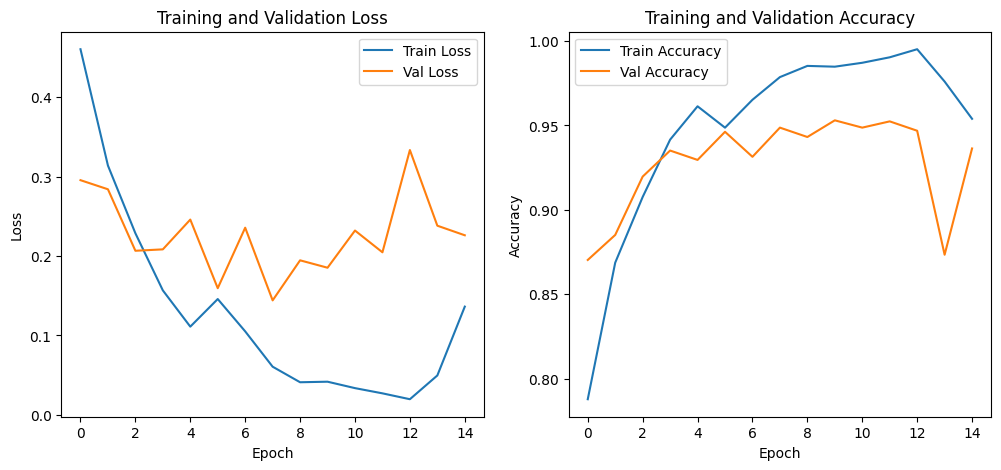

In [46]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(mff_history['train_loss'], label='Train Loss')
plt.plot(mff_history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(mff_history['train_acc'], label='Train Accuracy')
plt.plot(mff_history['val_acc'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

In [ ]:
def visualize_sample_prediction_mff(model, dataset, idx, device="cuda"):
    class_mapping = {0: "Normal", 1: "Myocardial Infarction"}
    
    model.eval()
    gaf_img, mtf_img, rp_img, label = dataset[idx]  
    label = int(label)  

    gaf_img, mtf_img, rp_img = (
        gaf_img.unsqueeze(0).to(device),
        mtf_img.unsqueeze(0).to(device),
        rp_img.unsqueeze(0).to(device),
    )
    
    with torch.no_grad():
        output = model(gaf_img, mtf_img, rp_img) 
        _, predicted_label = torch.max(output, 1) 
    
    gaf_np = gaf_img.squeeze(0).cpu().permute(1, 2, 0).numpy()
    mtf_np = mtf_img.squeeze(0).cpu().permute(1, 2, 0).numpy()
    rp_np = rp_img.squeeze(0).cpu().permute(1, 2, 0).numpy()
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(gaf_np, cmap="viridis")
    axes[0].set_title("GAF Image")
    axes[0].axis("off")
    
    axes[1].imshow(mtf_np, cmap="viridis")
    axes[1].set_title("MTF Image")
    axes[1].axis("off")
    
    axes[2].imshow(rp_np, cmap="viridis")
    axes[2].set_title("RP Image")
    axes[2].axis("off")
    
    plt.tight_layout()
    plt.show()
    
    print(f"Ground Truth Label: {label} ({class_mapping[label]})")
    print(f"Predicted Label: {predicted_label.item()} ({class_mapping[predicted_label.item()]})")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


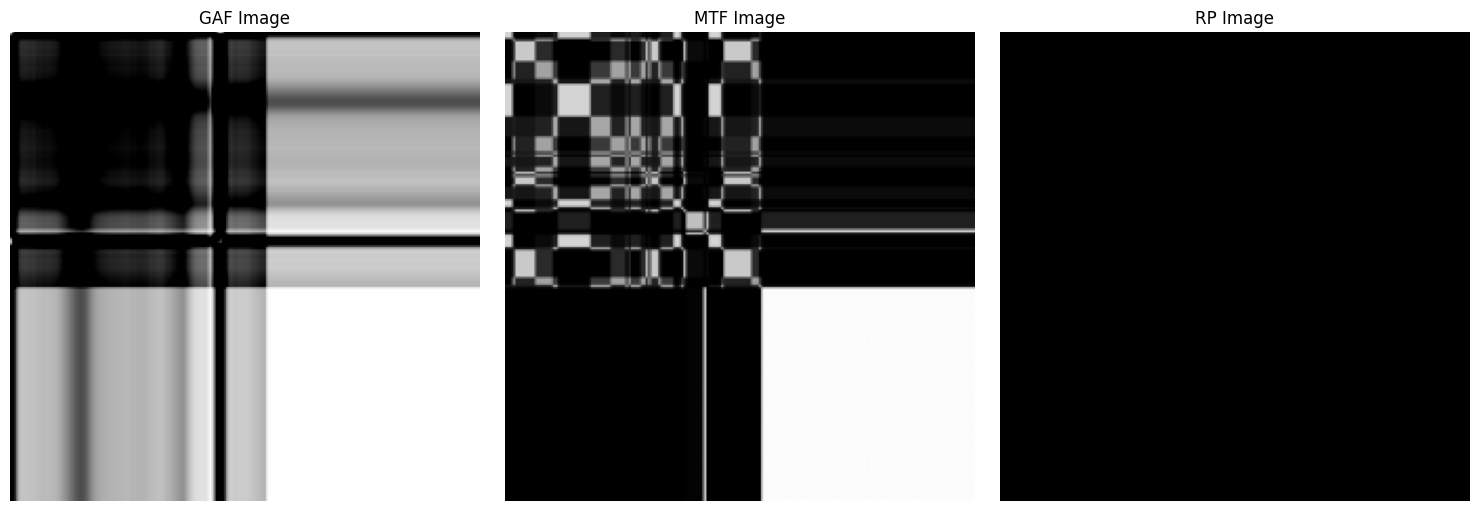

Ground Truth Label: 0 (Normal)
Predicted Label: 0 (Normal)


In [ ]:
sample_idx = 0  
visualize_sample_prediction_mff(mff_trained_model, dataset, sample_idx, device=device)